# Example Usage

Here we will load a small (synthetic) waterflood's production and injection data, then perform _CRM_ to estimate the connectivities, predict production, and compare the predictions to historical production

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pywaterflood import CRM

## Waterflood history matching

First, we pull production from 4 wells and injection from 5 wells over a 298 timestep period, then we create a CRM instance where the time constants are for injector-producer pairs (per-pair) and connectivity constants are limited to 1 for each injector-producer pair. Next, we fit and predict historical production.

In [3]:
gh_url = "https://raw.githubusercontent.com/frank1010111/pywaterflood/master/testing/data/"
prod = pd.read_csv(gh_url + "production.csv", header=None)
inj = pd.read_csv(gh_url + "injection.csv", header=None)
time = pd.read_csv(gh_url + "time.csv", header=None)

crm = CRM(tau_selection="per-pair", constraints="up-to one")
crm.fit(prod.values, inj.values, time.values[:, 0])
q_hat = crm.predict()

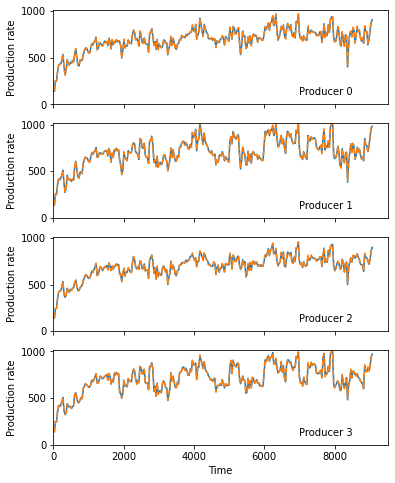

In [4]:
fig, axes = plt.subplots(len(prod.columns), figsize=(6, 8), sharex=True, sharey=True)
for i, p in enumerate(prod):
    axes[i].plot(time, prod[p], label="Production")
    axes[i].plot(time, q_hat[:, i], ls="--", label="Prediction")
    axes[i].set(xlim=(0, None), ylim=(0, None), ylabel="Production rate")
    axes[i].annotate(f"Producer {p}", xy=(7000, 100))
axes[i].set(xlabel="Time");

## Look at inter-well connectivity

Let's make a table of the connectivity and highlight the most important injector for each producer.

In [5]:
connectivity = pd.DataFrame(
    crm.gains,
    index=prod.columns.rename("Producer"),
    columns=inj.columns.rename("Injector"),
)
connectivity.T.style.highlight_max().format("{:.2}")

Producer,0,1,2,3
Injector,,,,
0,0.32,0.33,0.18,0.18
1,0.33,0.17,0.33,0.17
2,0.25,0.25,0.25,0.25
3,0.17,0.33,0.17,0.32
4,0.18,0.17,0.33,0.33


## Perform pressure-compensated CRM

In some cases, you have reliable pressure data for the producers in your waterflood. This is useful additional data that can improve the capacitance resistance model predictions. It was established by [Yousef _et al._ (2006)](https://onepetro.org/REE/article-abstract/9/06/630/196295) and perfected by [Kaviani _et al._ (2012)](https://www.sciencedirect.com/science/article/pii/S0920410512000915).



In [9]:
from pywaterflood import CrmCompensated

crm_p = CrmCompensated(tau_selection="per-pair", constraints="up-to one")
pressure = (1000 - prod * 0.1).values  # allow us to make something up
crm_p.fit(prod.values, pressure, inj.values, time.values[:, 0])
q_hat_p = crm_p.predict()

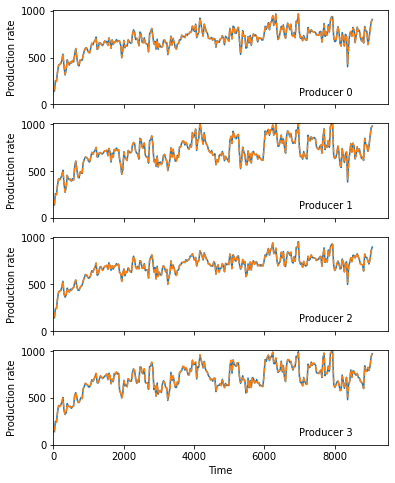

In [10]:
fig, axes = plt.subplots(len(prod.columns), figsize=(6, 8), sharex=True, sharey=True)
for i, p in enumerate(prod):
    axes[i].plot(time, prod[p], label="Production")
    axes[i].plot(time, q_hat_p[:, i], ls="--", label="Prediction")
    axes[i].set(xlim=(0, None), ylim=(0, None), ylabel="Production rate")
    axes[i].annotate(f"Producer {p}", xy=(7000, 100))
axes[i].set(xlabel="Time");